In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from numpy.ma.core import count
from prompt_toolkit.key_binding.bindings.named_commands import yank_pop

warnings.filterwarnings('ignore')

In [2]:
bd = pd.read_csv('final.csv')
bd['finish_dttm'] = pd.to_datetime(bd['finish_dttm'])
bd['age'] = bd['age'].str.replace(',', '.').astype(float)
bd['flag'] = (bd['wo_hit_status_result_desc'] == 'Дозвон, Успешно')
bd['flag'] = bd['flag'].astype(int)

days_of_week = bd['finish_dttm'].dt.day_name()
days_of_week_num = bd['finish_dttm'].dt.weekday
bd['day_of_week'] = days_of_week
bd['num_of_week'] = days_of_week_num

def vibrosi(bd, i, x):
    return pd.concat([bd[bd[i] < x], bd[bd[i].isna()]])
def vibrosiVniz(bd, i, x):
    return pd.concat([bd[bd[i] > x], bd[bd[i].isna()]])
def percentsByRegion(bd, i):
    df = bd.copy()
    pt = df[df['region_size'] == i][df['age'] >= 18][df['age'] < 60][['age', 'flag']].pivot_table(index='age', columns='product_cd', values='flag', aggfunc=['sum', 'count'])
    # pt['percent'] = pt[(  'sum', 'flag')] / pt[('count', 'flag')] * 100
    # pt[pt['percent'] != 0]

bd['child_flg'] = bd['child_amt'] != 0
bd['child_flg'] = bd['child_flg'].astype(int)

bd = vibrosi(bd, 'confirmed_income', 40000)
bd = vibrosi(bd, 'predicted_income', 45000)
bd = vibrosiVniz(bd, 'predicted_income', 0)
bd = vibrosiVniz(bd, 'age', 13)
# хочу делить по: age, auto_flg, partnership_flg, child_flg, realty_type, functional_cd, emp_work_months_cnt, emp_gender_cd, emp_age

df = bd.drop(bd[bd['wo_hit_status_reason_desc'].isin(['Отказ прослушать предложение', 'Не звонить', 'Левый контакт', 'Отказ от диалога', 'отказ от диалога', 'Отказ от разговора', 'Не звонить, резкий негатив', 'Негатив/Не звонить', 'Отказ без объяснения причин', 'просит не звонить', 'Не звонить / резкий негатив', 'Вежливо попросил не звонить', 'Номер не принадлежит страхователю', 'отказ без объяснения причин', 'Отказался озвучить причину', 'Чёрный список', 'негатив к Тинькофф', 'Грубо попросил не звонить', 'Не звонить (негатив)', 'Отказался от диалога', 'Просит больше не звонить', 'Недозвон', 'некорректная заявка', 'Техническая ошибка', 'Не нравится Т-Банк', 'Негатив к Т-Банку', 'Негативная информация о клиенте', 'Отказ без объяснения причины', 'Неизвестен / Не контактирует', 'Человек не участвовал в Дано', 'отменили'])].index)

df['income'] = df['confirmed_income'].fillna(df['predicted_income'])
df['segment_number'] = df['segment_cd'].str.extract(r'\((\d+)\)').astype(float)
df['num_segment'] = (df['segment_cd'].str[2:4])
df['num_segment'] = df['num_segment'].astype(float)

# Функция для определения сезона по номеру месяца
def get_season(month):
    if month in [12, 1, 2]:
        return 'Зима'
    elif month in [3, 4, 5]:
        return 'Весна'
    elif month in [6, 7, 8]:
        return 'Лето'
    elif month in [9, 10, 11]:
        return 'Осень'

# Преобразуем finish_dttm в datetime, если нужно
df['finish_dttm'] = pd.to_datetime(df['finish_dttm'])

# Извлекаем номер месяца
df['month'] = df['finish_dttm'].dt.month
df['hours'] = df['finish_dttm'].dt.hour

# Применяем функцию для создания нового столбца season
df['season'] = df['month'].apply(get_season)


In [92]:
emp = df[['employee_id', 'emp_age', 'emp_age_new', 'emp_gender_cd', 'emp_children_cnt', 'emp_work_months_cnt', 'state_talk_time_sec', 'flag']].groupby(by=['employee_id', 'emp_gender_cd']).mean()
emp.reset_index(inplace=True)
emp['time_uspeh'] = 0

def ok(id):
    return df[df['flag'] == 1][df['employee_id'] == id]['state_talk_time_sec'].mean()

emp['time_uspeh'] = emp['employee_id'].apply(ok)

def min(id):
    if len(df[df['flag'] == 1][df['employee_id'] == id]['employee_id'].tolist()) == 0:
        return 0
    return np.percentile(df[df['flag'] == 1][df['employee_id'] == id]['age'], 25)

def max(id):
    if len(df[df['flag'] == 1][df['employee_id'] == id]['employee_id'].tolist()) == 0:
        return 0
    return np.percentile(df[df['flag'] == 1][df['employee_id'] == id]['age'], 75)

emp['min_age'] = emp['employee_id'].apply(min)
emp['max_age'] = emp['employee_id'].apply(max)

# 1. Считаем успешность по employee_id и gender_cd
success_rates = (
    df.groupby(['employee_id', 'gender_cd'])['flag']
    .mean()
    .reset_index()
    .rename(columns={'flag': 'success_rate'})
)

# 2. Для каждого employee_id выбираем gender_cd с максимальной успешностью
best_gender_per_employee = (
    success_rates.loc[success_rates.groupby('employee_id')['success_rate'].idxmax()]
    [['employee_id', 'gender_cd']]
    .rename(columns={'gender_cd': 'lovely_gender_cd'})
)

emp = emp.merge(best_gender_per_employee, on='employee_id', how='left')

# Рассчитываем процент успешности по каждому оператору и продукту
success_rate = df[['employee_id', 'product_cd', 'flag']].groupby(['employee_id', 'product_cd'])['flag'].mean().reset_index()
success_rate.rename(columns={'flag': 'success_rate'}, inplace=True)

# Для каждого оператора выбираем продукт с наибольшим процентом успешности
best_product = success_rate.loc[success_rate.groupby('employee_id')['success_rate'].idxmax()]

# Добавляем столбец best_product в исходный DataFrame
emp = emp.merge(best_product[['employee_id', 'product_cd']], on='employee_id', how='left')
emp.rename(columns={'product_cd': 'best_product'}, inplace=True)

emp = emp.rename({'flag' : 'emp_mean_flag'}, axis=1)

df_plus_emp = df.merge(emp[['employee_id', 'emp_mean_flag', 'time_uspeh', 'min_age', 'max_age', 'lovely_gender_cd', 'best_product']], on='employee_id', how='left')
df_plus_emp['emps_product'] = (df_plus_emp['product_cd'] == df_plus_emp['best_product']).astype(int)

df_plus_emp['female_matching'] = ((df_plus_emp['gender_cd'] == 'F') & (df_plus_emp['emp_gender_cd'] == 'W')).astype(int)
df_plus_emp['male_matching'] = ((df_plus_emp['gender_cd'] == 'M') & (df_plus_emp['emp_gender_cd'] == 'M')).astype(int)
df_plus_emp['gender_matching'] = ((df_plus_emp['female_matching'] == 1) | (df_plus_emp['male_matching'] == 1)).astype(int)
df_plus_emp['age_matching'] = ((df_plus_emp['age'] - df_plus_emp['emp_age']).abs() <= 5).astype(int)

df_plus_emp['lovely_gender_cd_encoded'] = (df_plus_emp['lovely_gender_cd'] == 'M').astype(int)

df_plus_emp['emps_lovely_age'] = ((df_plus_emp['min_age'] < df_plus_emp['age']) & (df_plus_emp['age'] < df_plus_emp['max_age'])).astype(int)

df_plus_emp['child_by_emp_and_cd_flg'] = ((df_plus_emp['child_amt'] > 0) * (df_plus_emp['emp_children_cnt'] > 0)).astype(int)

def sha_budet_rok(x):
    if x <= 25:
        return '14-25'
    elif x <= 35:
        return '26-35'
    elif x <= 45:
        return '36-45'
    elif x <= 60:
        return '45-60'
    else:
        return '60+'


df_plus_emp['age_groups_cd'] = df_plus_emp['age'].apply(lambda x: sha_budet_rok(x))
df_plus_emp['age_groups_emp'] = df_plus_emp['emp_age_new'].apply(lambda x: sha_budet_rok(x))
df_plus_emp['age_group_matching'] = (df_plus_emp['age_groups_cd'] == df_plus_emp['age_groups_emp']).astype(int)


In [6]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

g1 = df_plus_emp[df_plus_emp['product_cd'].isin(['Credit Cards', 'Cash Loan', 'Secured Loan', 'Car Loan'])][['flag', 'gender_cd', 'gender_match', 'auto_flg', 'emp_gender_cd', 'partnership_flg', 'emp_age_new', 'emp_work_months_cnt', 'age', 'income', 'child_flg', 'emps_lovely_age', 'realty_type', 'lovely_gender_cd_encoded', 'age_group_matching']]

logit_res = smf.glm('flag ~ C(gender_cd) + C(gender_match) + C(auto_flg) + C(emp_gender_cd) + C(partnership_flg) + C(realty_type) \
+ emp_age_new + emp_work_months_cnt + age + income + C(child_flg) + C(lovely_gender_cd_encoded) + C(age_group_matching)', g1, family = sm.families.Binomial()).fit()
logit_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                   flag   No. Observations:                 1943
Model:                            GLM   Df Residuals:                     1927
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -599.02
Date:                Tue, 10 Dec 2024   Deviance:                       1198.0
Time:                        21:49:25   Pearson chi2:                 1.87e+03
No. Iterations:                    21   Pseudo R-squ. (CS):            0.05374
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -3.4220      0.941     -3.638      0.000      -5.266      -1.578
C(gender_cd)[T.M]                     -0.0455      0.168     -0.271      0.786      -0.375       0.284
C(gender_match)[T.1]                  -0.4702      0.556     -0.846      0.398      -1.560       0.620
C(auto_flg)[T.1.0]                     0.1078      0.166      0.649      0.517      -0.218       0.433
C(emp_gender_cd)[T.W]                 -0.1772      0.380     -0.467      0.641      -0.921       0.567
C(partnership_flg)[T.1.0]              0.1426      0.210      0.680      0.497      -0.268       0.554
C(realty_type)[T.Квартира]            -0.5217      0.788     -0.662      0.508      -2.066       1.022
C(realty_type)[T.Комната]            -20.5282   1.31e+04     -0.002      0.999   -2.56e+04    2.56e+04
C(realty_type)[T.Нет своего жилья]    -0.3527      0.786     -0.449      0.654      -1.893       1.188
C(child_flg)[T.1]                     -0.1969      0.178     -1.103      0.270      -0.547       0.153
C(lovely_gender_cd_encoded)[T.1]      -0.3087      0.159     -1.937      0.053      -0.621       0.004
C(age_group_matching)[T.1]             0.2253      0.180      1.248      0.212      -0.128       0.579
emp_age_new                            0.0236      0.006      3.837      0.000       0.012       0.036
emp_work_months_cnt                    0.0151      0.002      6.678      0.000       0.011       0.020
age                                    0.0147      0.007      2.029      0.042       0.001       0.029
income                             -2.299e-06   1.43e-05     -0.161      0.872   -3.03e-05    2.57e-05
======================================================================================================
"""

In [8]:
from scipy.stats import chi2_contingency

def KOSTIL(df, i, j):
    while i <= j:
        df = df[df['num_segment'] != i]
        i += 1
    return df

df_credit = df_plus_emp[df_plus_emp['functional_cd'].isin(['Upsell', 'Downsell'])]

# Таблица сопряженности: low_income_flg и flag (успех)
contingency_table = pd.crosstab(df_plus_emp['age_group_matching'], df_plus_emp['flag'])

# Тест хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)
  
print("Хи-квадрат статистика:", chi2)
print("p-value:", p)

# Интерпретация
if p < 0.05:
    print("Гипотеза подтверждена: низкий доход влияет на успешность апселла")
else:
    print("Гипотеза не подтверждена: связь между доходом и успешностью отсутствует")

Хи-квадрат статистика: 0.3852649801183855
p-value: 0.534798890061345
Гипотеза не подтверждена: связь между доходом и успешностью отсутствует


In [9]:
df_plus_emp['product_cd'].value_counts()

product_cd
Credit Cards          7401
Cash Loan             2402
MVNO                  1652
Debit Cards           1529
Investment             565
Secured Loan           435
Casco                  291
Mortgage Insurance     246
Car Loan               237
Osago                   23
Deposit                  8
Travel Avia              5
T-Auto                   2
Name: count, dtype: int64

In [97]:
from scipy.stats import chi2_contingency
from itertools import combinations

def KOSTIL(df, i, j):
    while i <= j:
        df = df[df['num_segment'] != i]
        i += 1
    return df

products = ['Credit Cards', 'Cash Loan', 'MVNO', 'Secured Loan', 'Car Loan', 'Debit Cards', 'Investment', 'Casco', 'Mortgage Insurance']
p_val = 123
ibest = -1
best = {}
lol = []

for i in range(1, 10):
    all_combinations = list(combinations(products, i))
    for wtf in all_combinations:
        df_credit = df_plus_emp[df_plus_emp['product_cd'].isin(wtf)].copy()
        if i != 1 and df_credit.shape[0] < 800:
            continue
        contingency_table = pd.crosstab(df_credit['male_matching'], df_credit['flag'])
        
        # Тест хи-квадрат
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        if i == 1:
            print(f'{wtf[0]}: {p:.3f}')
        
        if df_credit.shape[0] < 800:
            continue
        
        if p < 0.05:
            for j in wtf:
                if j not in best:
                    best[j] = 1
                else:
                    best[j] += 1
        
        if p < p_val:
            p_val = p
            ibest = i
            lol = wtf
    print(f'{i/9*100:.4}%')


df_credit = df_plus_emp[df_plus_emp['product_cd'].isin(lol)].copy()
contingency_table = pd.crosstab(df_credit['male_matching'], df_credit['flag'])

# Тест хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)
  
print(f"Хи-квадрат статистика: {chi2:.3f}")
print(f"p-value: {p:.3f}")
print("product_cd:", lol)

# Интерпретация
if p < 0.05:
    print("Гипотеза подтверждена: совпадения гендеров влияет на успешность звонка")
else:
    print("Гипотеза не подтверждена: связь между совпадением гендеров и успешностью отсутствует")

print()
for i in best:
    print(f'{i}: {best[i]}')

Credit Cards: 0.024
Cash Loan: 0.887
MVNO: 0.000
Secured Loan: 0.110
Car Loan: 0.362
Debit Cards: 0.007
Investment: 0.468
Casco: 0.310
Mortgage Insurance: 0.090
11.11%
22.22%
33.33%
44.44%
55.56%
66.67%
77.78%
88.89%
100.0%
Хи-квадрат статистика: 23.377
p-value: 0.000
product_cd: ('Cash Loan', 'MVNO', 'Investment')
Гипотеза подтверждена: совпадения гендеров влияет на успешность звонка

Credit Cards: 85
MVNO: 130
Debit Cards: 53
Cash Loan: 90
Secured Loan: 94
Car Loan: 94
Mortgage Insurance: 94
Investment: 81
Casco: 90


In [149]:
df_credit = df_plus_emp[df_plus_emp['functional_cd'].isin(['Activation', 'BAF', 'Preapprove', 'Afterfilling', 'Utilization'])].copy()
df_credit.shape[0]

10152

In [215]:
import pandasql as ps


df_credit = df_plus_emp.copy()
df_credit = df_credit.reset_index()

q1 = """
SELECT * FROM df_credit
WHERE "index" NOT IN (
    SELECT "index" FROM df_credit
    WHERE "wo_hit_status_reason_desc" IN (
        "Другое", "Третье лицо", "Отказ по всем продуктам", 
        "Не хочет разбираться", "Устраивает свой оператор",
        "Не интересно", "Другой банк", "Действующий клиент",
        "Клиент ранее отказался", "Другое (нестандартная ситуация)",
        "Уже является абонентом Т-Мобайл", "Сам разберется",
        "Не соответствует по возрасту", "Уже оставил заявку",
        "Не требуется сейчас", "Нет потребности",
        "Не соответствует по возрасту", "Другое;Обратится самостоятельно",
        "Пользуется картой другого банка", "Уже является абонентом Т-Мобайла",
        "Кредит / КК в другом банке", "Другое;Отказ от маркетинговых коммуникаций",
        "Другое (укажи в комментарии)", "Перезвонит самостоятельно",
        "Уже является абонентом ТМ", "Некорректный трансфер",
        "Не соответствует требованиям", "Уже застрахован",
        "Пользуется другим брокером", "Уже утилизирован",
        "Просто интересовался условиями", "Другое;Дубль заявки",
        "Взял кредит в другом банке", "3 лицо;Не знаком с клиентом, 3-е лицо",
        "Пользуется сим другого провайдера", "Отказ от маркетинговых коммуникаций",
        "Другое;Действующий клиент. Вопрос по текущему продукту, нецелевому кейсу",
        "В списке нет подходящей причины", "Уже продлил в Тинькофф чаты/МП",
        "Некорректно передан из офиса", "Отказ предоставить персональные данные",
        "3 лицо;Номер не принадлежит страхователю", "Отказ предоставить данные для заявки",
        "Другое;Перевод в офис (нестандартная ситуация)", "В списке нет подходящей причины (укажи в комментариях)",
        "Сложный кейс"
    )
)
"""

df_credit = ps.sqldf(q1, locals())
df_credit.shape[0]

10286

In [165]:
# df_credit = df_plus_emp[df_plus_emp['functional_cd'].isin(['Activation', 'BAF', 'Preapprove', 'Afterfilling', 'Utilization'])].copy()
contingency_table = pd.crosstab(df_credit['flag'], df_credit['gender_matching'])

# Тест хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)
  
print("Хи-квадрат статистика:", chi2)
print("p-value:", p)
print("product_cd:", lol)

# Интерпретация
if p < 0.05:
    print("Гипотеза подтверждена: совпадения возрастной группы влияет на успешность звонка")
else:
    print("Гипотеза не подтверждена: связь между возрастной группой и успешностью отсутствует")


Хи-квадрат статистика: 2.1997547163183198
p-value: 0.13803270008962182
product_cd: ('Cash Loan', 'MVNO', 'Investment')
Гипотеза не подтверждена: связь между возрастной группой и успешностью отсутствует


In [152]:
df_plus_emp[df_plus_emp['functional_cd'].isin(['Activation', 'BAF', 'Preapprove', 'Afterfilling', 'Utilization'])][['gender_cd', 'gender_matching', 'flag']].groupby(by=['gender_cd', 'gender_matching']).mean()

flag
gender_cd gender_matching          
F         0                0.109818
          1                0.121285
M         0                0.140984
          1                0.159255

In [153]:
contingency_table

gender_matching,0,1
flag,,
0,3464,2622
1,785,557


In [26]:
df_plus_emp['flag'].mean()

np.float64(0.16308461746417952)

In [145]:
df_credit[df_credit['gender_matching'] == 1]['flag']

0       0
1       0
2       0
3       0
4       0
       ..
2719    0
2720    0
2721    0
2722    0
2723    0
Name: flag, Length: 2724, dtype: int64

In [67]:
for i in df['functional_cd'].unique():
    print(f'{i}: ')

Meeting: 
Agreement: 
Upsell: 
Afterfilling: 
Cold: 
Preapprove: 
Activation: 
Utilization: 
Downsell: 
Reutilization: 
BAF: 
Autoleads: 
Prolongation: 
Incoming: 
Deposit: 
Refinancing: 


In [216]:
# df_credit = df_plus_emp[df_plus_emp['functional_cd'].isin(['Activation', 'BAF', 'Preapprove', 'Afterfilling', 'Utilization'])].copy()
df_gypotesa_1 = df_credit[df_credit['product_cd'] == 'Credit Cards'].copy()
df_gypotesa_1['age35'] = (df_gypotesa_1['age'] > 35).astype(int)

contingency_table = pd.crosstab(df_gypotesa_1['age35'], df_gypotesa_1['flag'])

# Тест хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)
  
print("Хи-квадрат статистика:", chi2)
print("p-value:", p)
# print("product_cd:", lol)

# Интерпретация
if p < 0.05:
    print("Гипотеза подтверждена: совпадение гендеров влияет на успешность звонка")
else:
    print("Гипотеза не подтверждена: связь между возрастной группой и успешностью отсутствует")


Хи-квадрат статистика: 8.392427047442682
p-value: 0.0037678747003782806
Гипотеза подтверждена: совпадение гендеров влияет на успешность звонка


In [217]:
df_gypotesa_1['functional_cd'].unique()

array(['Meeting', 'Preapprove', 'Downsell', 'Utilization',
       'Reutilization', 'Afterfilling'], dtype=object)

In [81]:
df_plus_emp[df_plus_emp['functional_cd'].isin(['Activation', 'BAF', 'Preapprove', 'Afterfilling', 'Utilization'])]['flag'].mean()

np.float64(0.1328802206461781)

In [139]:
df_credit[df_credit['emp_gender_cd'] == 'M'][df_credit['gender_cd'] == 'M']

,Unnamed: 0,customer_id,age,gender_cd,region_size,foreign_flg,entrepreneur_flg,auto_flg,traveler_flg,partnership_flg,...,female_matching,male_matching,gender_matching,age_matching,lovely_gender_cd_encoded,emps_lovely_age,child_by_emp_and_cd_flg,age_groups_cd,age_groups_emp,age_group_matching
7,1606,410196959,18.0,M,town,0.0,0.0,0.0,0.0,0.0,...,0,1,1,0,0,0,0,14-25,26-35,0
31,5380,309284298,34.0,M,rural,0.0,0.0,1.0,1.0,1.0,...,0,1,1,0,1,0,0,26-35,26-35,1
38,6767,531272054,48.0,M,town,0.0,0.0,1.0,0.0,1.0,...,0,1,1,0,0,0,0,45-60,14-25,0
48,7357,516349639,31.0,M,town,0.0,0.0,1.0,0.0,1.0,...,0,1,1,0,1,1,0,26-35,14-25,0
51,7889,303643007,38.0,M,town,0.0,0.0,0.0,0.0,0.0,...,0,1,1,0,1,1,0,36-45,14-25,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2677,18555,387456657,51.0,M,town,0.0,0.0,1.0,0.0,1.0,...,0,1,1,0,1,0,0,45-60,14-25,0
2679,18568,333820766,16.0,M,town,0.0,0.0,0.0,0.0,0.0,...,0,1,1,0,1,0,0,14-25,14-25,1
2680,18578,129875643,31.0,M,urban,0.0,0.0,1.0,0.0,1.0,...,0,1,1,0,1,0,0,26-35,14-25,0
2686,18627,214597107,26.0,M,town,0.0,0.0,0.0,0.0,1.0,...,0,1,1,0,1,0,0,26-35,14-25,0


In [107]:
df_plus_emp[df_plus_emp['functional_cd'] == 'Utilization']['product_cd'].unique()

array(['Investment', 'Credit Cards', 'Debit Cards', 'MVNO'], dtype=object)

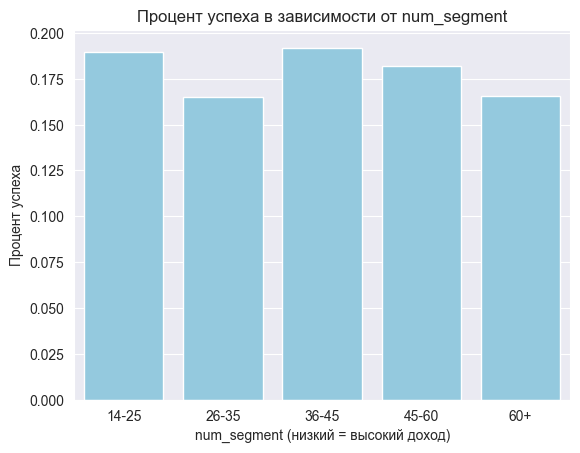

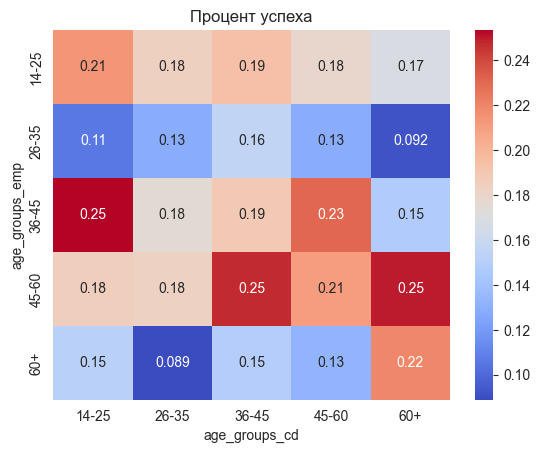

In [173]:
# Группировка по num_segment
success_by_segment = df_credit.groupby('age_groups_cd')['flag'].mean().reset_index()

# Визуализация успеха по num_segment
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='age_groups_cd', y='flag', data=success_by_segment, color='skyblue')
plt.title('Процент успеха в зависимости от num_segment')
plt.xlabel('num_segment (низкий = высокий доход)')
plt.ylabel('Процент успеха')
plt.show()

# Сводная таблица по region_size и num_segment
pivot = df_credit.pivot_table(values='flag', index='age_groups_emp', columns='age_groups_cd', aggfunc='mean')
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title('Процент успеха')
plt.show()

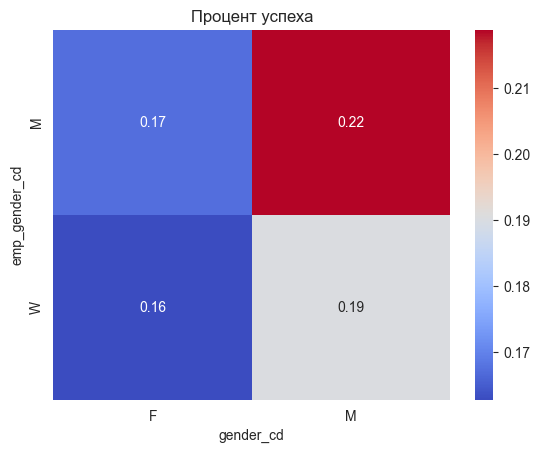

In [176]:
# Сводная таблица по region_size и num_segment
pivot = df_credit.pivot_table(values='flag', index='emp_gender_cd', columns='gender_cd', aggfunc='mean')
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title('Процент успеха')
plt.show()

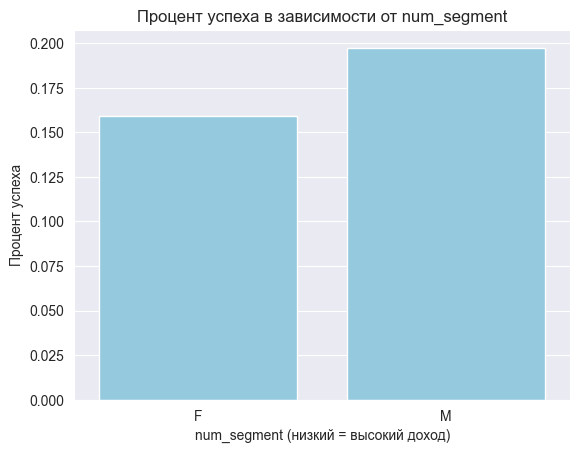

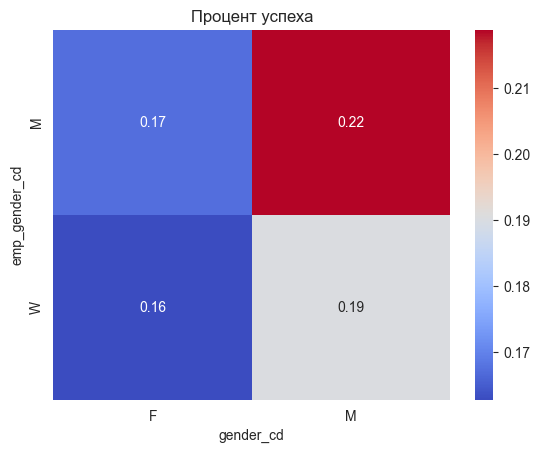

In [169]:
# Группировка по num_segment
success_by_segment = df_credit.groupby('gender_cd')['flag'].mean().reset_index()

# Визуализация успеха по num_segment
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='gender_cd', y='flag', data=success_by_segment, color='skyblue')
plt.title('Процент успеха в зависимости от num_segment')
plt.xlabel('num_segment (низкий = высокий доход)')
plt.ylabel('Процент успеха')
plt.show()

# Сводная таблица по region_size и num_segment
pivot = df_credit.pivot_table(values='flag', index='emp_gender_cd', columns='gender_cd', aggfunc='mean')
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title('Процент успеха')
plt.show()

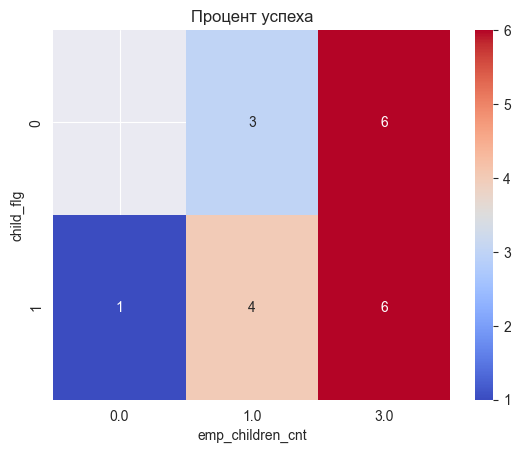

In [178]:
pivot = df_credit.pivot_table(values='flag', index='child_flg', columns='emp_children_cnt', aggfunc='count')
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title('Процент успеха')
plt.show()

In [180]:
df_credit[df_credit['child_flg'] == 0]

,index,Unnamed: 0,customer_id,age,gender_cd,region_size,foreign_flg,entrepreneur_flg,auto_flg,traveler_flg,...,female_matching,male_matching,gender_matching,age_matching,lovely_gender_cd_encoded,emps_lovely_age,child_by_emp_and_cd_flg,age_groups_cd,age_groups_emp,age_group_matching
1,21,710,326663782,21.0,F,town,0.0,0.0,1.0,0.0,...,1,0,1,0,1,0,0,14-25,60+,0
3,30,1187,397419981,34.0,M,town,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,26-35,14-25,0
4,32,1219,506166284,24.0,F,town,0.0,1.0,0.0,0.0,...,1,0,1,0,1,1,0,14-25,36-45,0
5,37,1332,285227095,23.0,M,town,0.0,0.0,1.0,0.0,...,0,0,0,1,0,0,0,14-25,14-25,1
6,38,1338,68791731,33.0,F,town,0.0,0.0,0.0,0.0,...,1,0,1,0,1,0,0,26-35,60+,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7412,14759,14213,523479311,NaN,None,rural,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,60+,36-45,0
7416,14771,16372,572944033,NaN,None,town,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,60+,36-45,0
7417,14772,16374,420501254,NaN,F,urban,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,60+,36-45,0
7424,14787,17761,371460142,NaN,None,rural,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,60+,14-25,0


Casco: 207


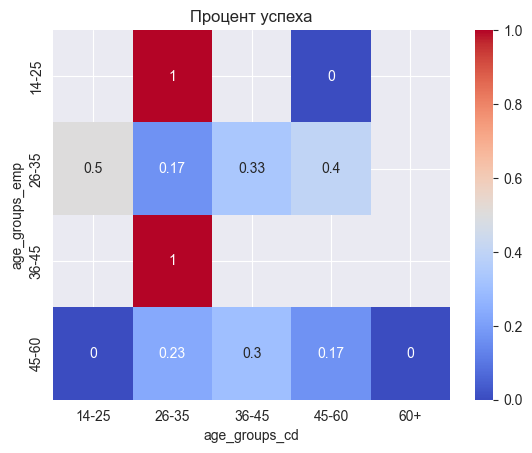

Credit Cards: 5541


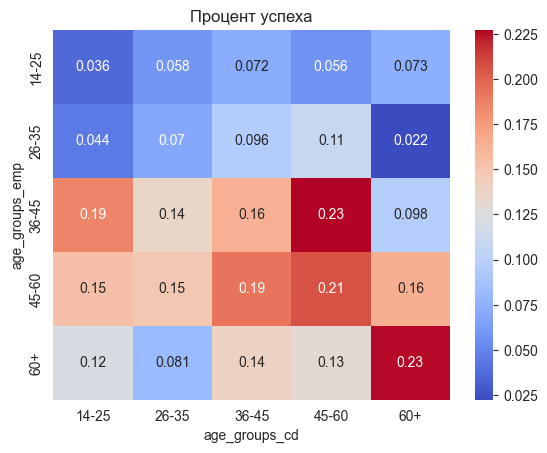

Cash Loan: 663


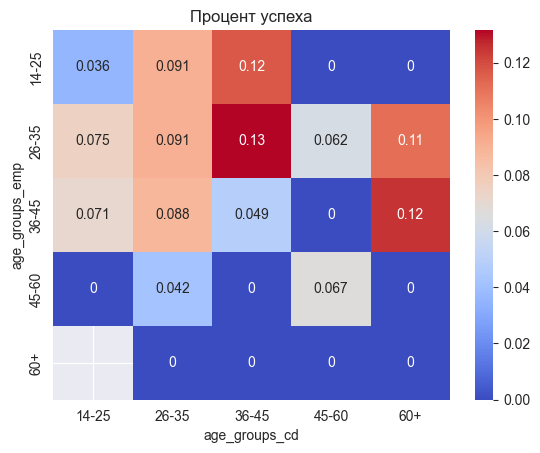

MVNO: 271


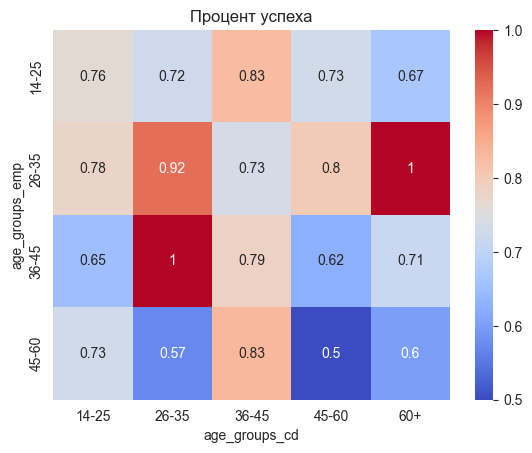

Mortgage Insurance: 24


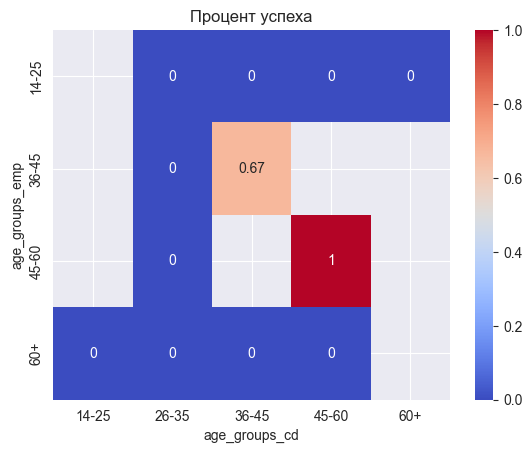

Investment: 143


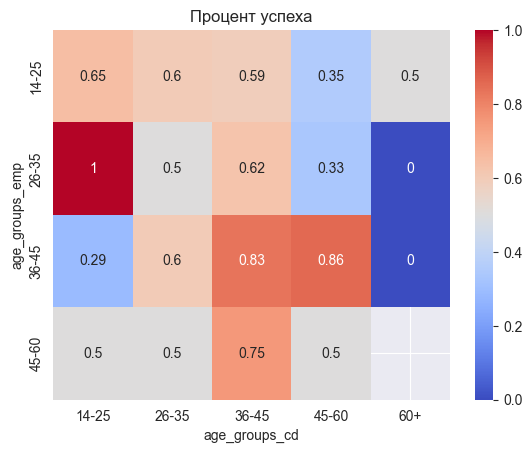

Car Loan: 60


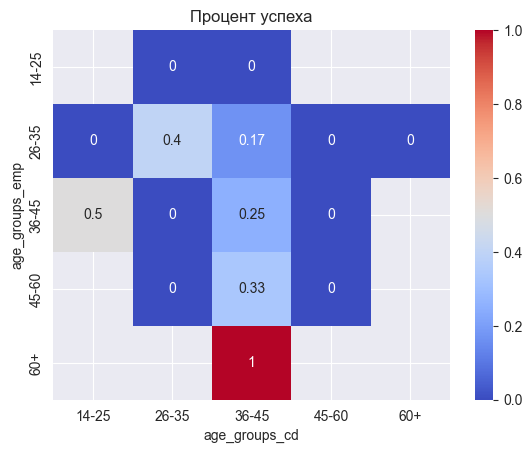

Debit Cards: 506


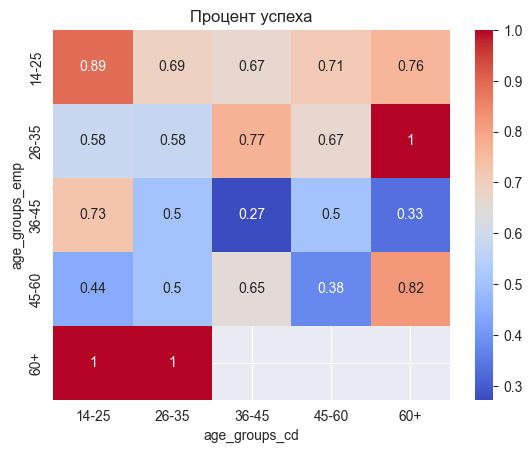

Secured Loan: 13


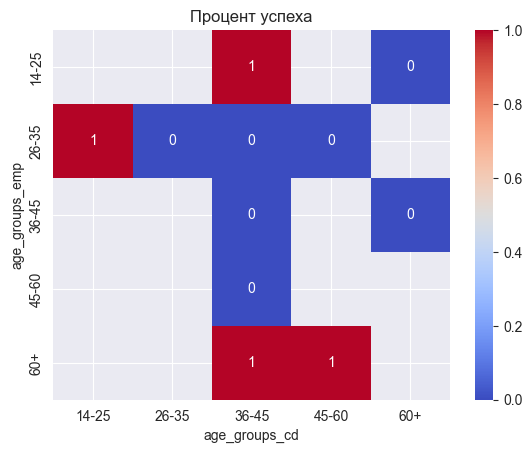

In [189]:
def heatmap(df):
    pivot = df.pivot_table(values='flag', index='age_groups_emp', columns='age_groups_cd', aggfunc='mean')
    sns.heatmap(pivot, annot=True, cmap='coolwarm')
    plt.title('Процент успеха')
    plt.show()

for i in df_credit['product_cd'].unique():
    now = df_credit[df_credit['product_cd'] == i]
    print(f'{i}: {now.shape[0]}')
    heatmap(now)

In [198]:
def watafak(id):
    c = len(df[df['customer_id'] == id]['employee_id'].tolist())
    return c

emp['emp_in_users'] = emp['employee_id'].apply(watafak)

In [200]:
df_plus_emp['is_easy'] = (df['functional_cd'].isin(['Activation', 'BAF', 'Preapprove', 'Afterfilling', 'Utilization'])).astype(int)

In [211]:
df_plus_emp[['is_easy', 'flag', 'state_talk_time_sec']].groupby(by=['flag', 'is_easy']).agg(['mean', 'count'])

state_talk_time_sec      
                            mean count
flag is_easy                          
0    0.0               74.106376  3074
     1.0               73.814062  6642
1    0.0              262.957307   609
     1.0              237.093651  1260

In [210]:
df_plus_emp[[ 'age_groups_emp', 'flag']].groupby(by=['age_groups_emp']).agg(['mean', 'count'])

flag      
                    mean count
age_groups_emp                
14-25           0.149951  5075
26-35           0.132941  3400
36-45           0.183762  2759
45-60           0.208935  2977
60+             0.121368   585

In [212]:
df_gypotesa_1

,index,Unnamed: 0,customer_id,age,gender_cd,region_size,foreign_flg,entrepreneur_flg,auto_flg,traveler_flg,...,male_matching,gender_matching,age_matching,lovely_gender_cd_encoded,emps_lovely_age,child_by_emp_and_cd_flg,age_groups_cd,age_groups_emp,age_group_matching,age35
1,21,710,326663782,21.0,F,town,0.0,0.0,1.0,0.0,...,0,1,0,1,0,0,14-25,60+,0,0
2,29,1178,480706447,44.0,M,town,0.0,0.0,0.0,0.0,...,0,0,0,1,1,0,36-45,60+,0,1
3,30,1187,397419981,34.0,M,town,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,26-35,14-25,0,0
6,38,1338,68791731,33.0,F,town,0.0,0.0,0.0,0.0,...,0,1,0,1,0,0,26-35,60+,0,0
7,49,1708,447394749,18.0,M,town,0.0,0.0,0.0,0.0,...,1,1,0,1,0,0,14-25,36-45,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7416,14771,16372,572944033,NaN,None,town,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,60+,36-45,0,0
7419,14774,16492,473146702,NaN,None,None,NaN,NaN,NaN,NaN,...,0,0,0,1,0,0,60+,36-45,0,0
7424,14787,17761,371460142,NaN,None,rural,0.0,1.0,1.0,0.0,...,0,0,0,0,0,0,60+,14-25,0,0
7425,14790,18110,525669032,NaN,F,None,NaN,NaN,NaN,NaN,...,0,1,0,1,0,0,60+,36-45,0,0


механизм: люди в возрасте 35+ лучше разбираются с кредитными картами и лучше могут объяснить клиентам все вопросы, связаные с кредитными картами;\n
Альтернативный механизм: люди в возрасте до 35 чаще имеют маленький опыт работы и хуже знают нюансы

In [232]:
df_gypotesa_2 = df_gypotesa_1[df_gypotesa_1['emp_work_months_cnt'] >= 0]
percentile25 = np.percentile(df_gypotesa_2['emp_work_months_cnt'].dropna(), 25)
df_gypotesa_2['small_work'] = (df_gypotesa_2['emp_work_months_cnt'] < percentile25).astype(int)
df_gypotesa_2.pivot_table(index='age_groups_emp', values='small_work', aggfunc='sum')

,small_work
age_groups_emp,
14-25,558
26-35,156
36-45,154
45-60,100
60+,7


In [238]:
df_gypotesa_2.shape[0]

5609

In [239]:
contingency_table = pd.crosstab(df_gypotesa_2['small_work'], df_gypotesa_2['flag'])

# Тест хи-квадрат
chi2, p, dof, expected = chi2_contingency(contingency_table)
  
print("Хи-квадрат статистика:", chi2)
print("p-value:", p)
# print("product_cd:", lol)

# Интерпретация
if p < 0.05:
    print("Гипотеза подтверждена: совпадение гендеров влияет на успешность звонка")
else:
    print("Гипотеза не подтверждена: связь между возрастной группой и успешностью отсутствует")


Хи-квадрат статистика: 63.90669992928005
p-value: 1.3045324245585324e-15
Гипотеза подтверждена: совпадение гендеров влияет на успешность звонка


In [242]:
emp.shape[0]

561